In [76]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [77]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
matplotlib.rcParams.update({'font.size': 14})

In [79]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
   
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [80]:
TRAIN_DATASET_PATH = 'project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'project_task/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [81]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [82]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [83]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [84]:
# test_id = test_df["Id"]
# pred_df = pd.DataFrame()
# pred_df["Id"] = test_id
# pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
# assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

# pred_df.to_csv("./predictions_.csv", index=False)

### Разбиение на train и valid

In [85]:
feature_names = ['Id','DistrictId','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price']

#new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [86]:
X = train_df[feature_names]
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21) # test_size=0.33 ????
X_valid = X_valid.drop('Price', axis=1)

In [87]:
X_train.shape

(6700, 20)

In [88]:
X_valid.shape

(3300, 19)

In [89]:
X_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [90]:
X_train.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [91]:
X_train['Id'] = X_train['Id'].astype(str)
X_train['DistrictId'] = X_train['DistrictId'].astype(str)

## Обзор данных

### Целевая переменная

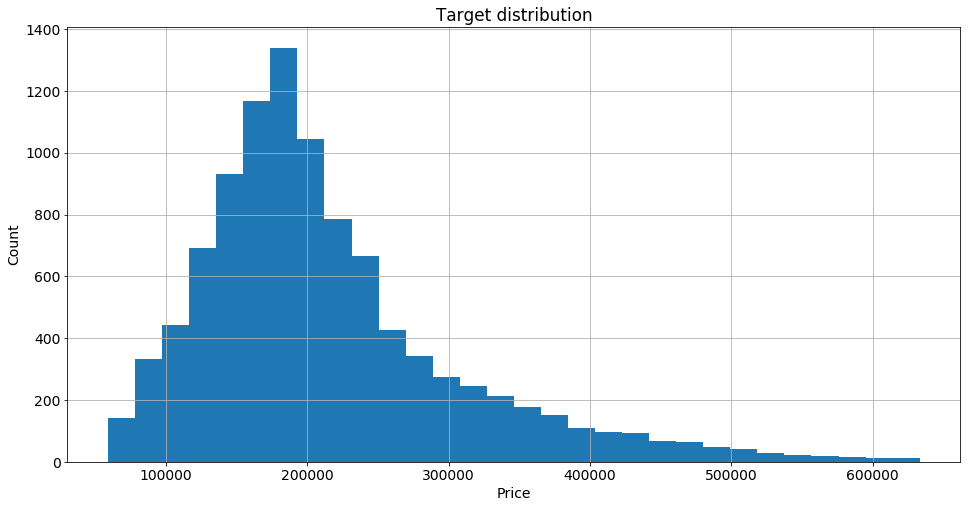

In [92]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные

In [93]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,6700.000000,6700.000000,5260.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,3481.000000,6700.000000,6700.000000,6700.000000
mean,1.882537,56.081497,37.415591,6.438060,8.494776,12.647463,1985.154776,0.118740,24.670597,5333.197463,7.952985,1150.579718,1.332836,4.222985,213872.986633
std,0.815633,20.468093,104.661936,34.688095,5.220311,6.803397,40.872731,0.119600,17.459441,3977.675264,23.718438,1021.277009,1.510859,4.812391,92638.972848
min,0.000000,1.988943,0.370619,0.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.798893,22.711308,1.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153994.680334
50%,2.000000,52.083642,32.505331,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192817.509808
75%,2.000000,65.790145,44.768302,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249080.956886
max,10.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178


### Категориальные признаки

In [94]:
cat_colnames = X_train.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [95]:
for cat_colname in cat_colnames[2:]:
    # print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    print(str(cat_colname) + '\n\n' + str(X_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    6625
A      75
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    6516
A     184
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    6151
A     549
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

In [96]:
X_train['Rooms'].value_counts()

2.0     2633
1.0     2485
3.0     1467
4.0       95
5.0       13
0.0        5
10.0       1
6.0        1
Name: Rooms, dtype: int64

In [97]:
X_train['Rooms'].shape

(6700,)

In [98]:
X_train['Rooms'].median()

2.0

In [99]:
X_train.loc[X_train['Rooms'].isin([0, 10]), 'Rooms'] = X_train['Rooms'].median()

In [100]:
X_train['Rooms'].value_counts()

2.0    2639
1.0    2485
3.0    1467
4.0      95
5.0      13
6.0       1
Name: Rooms, dtype: int64

In [101]:
X_train['Rooms'].shape

(6700,)

In [102]:
X_train['Square'].sort_values(ascending=True)

8283      1.988943
4853      2.377248
1608      2.596351
3280      4.380726
4900      4.390331
           ...    
652     190.857689
9910    200.334539
1981    212.932361
1982    275.645284
6977    641.065193
Name: Square, Length: 6700, dtype: float64

In [103]:
X_train['Square'].sort_values().unique()

array([  1.98894272,   2.37724759,   2.59635118, ..., 212.93236105,
       275.64528408, 641.06519275])

In [104]:
X_train[X_train['Square'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
4853,3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


In [105]:
X_train['Square'][X_train['Square'] < 10]

8030    4.823679
9613    4.502784
8283    1.988943
212     5.497061
3280    4.380726
4900    4.390331
1608    2.596351
4853    2.377248
Name: Square, dtype: float64

In [106]:
 X_train['Square'].quantile(.99)

117.7149148572765

In [107]:
X_train['Square'].quantile(.01)

29.412864149358583

In [108]:
X_train[X_train['Square'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [109]:
X_train['Square'].median()

52.08364248736403

In [110]:
X_train.loc[X_train['Square'] > X_train['Square'].quantile(.99), 'Square'] = X_train['Square'].median()  
X_train.loc[X_train['Square'] < X_train['Square'].quantile(.01), 'Square'] = X_train['Square'].median()

In [111]:
X_train['Square'].sort_values(ascending=True)

2274     29.412873
6001     29.415990
5381     29.554603
3023     29.563428
381      29.567101
           ...    
5902    116.500215
9852    117.201937
8086    117.300024
8824    117.370746
3228    117.714551
Name: Square, Length: 6700, dtype: float64

In [89]:
# X_train = X_train[X_train['Square'].isnull() |
#                     (X_train['Square'] < X_train['Square'].quantile(.99)) &
#                     (X_train['Square'] > X_train['Square'].quantile(.01))]
# X_train = X_train[(X_train['Square'] < X_train['Square'].quantile(.99)) &    # ?????? Зачем X_train['Square'].isnull() |
#                   (X_train['Square'] > X_train['Square'].quantile(.01))]

In [112]:
X_train['Square']

9239    39.458190
6930    57.088640
8136    32.777610
3424    37.752079
6518    31.702237
          ...    
9336    38.476449
48      47.080100
8964    74.132699
5944    63.911398
5327    39.314342
Name: Square, Length: 6700, dtype: float64

In [113]:
X_train['Square'][X_train['Square'] > 117]

9852    117.201937
3228    117.714551
8086    117.300024
8824    117.370746
Name: Square, dtype: float64

In [114]:
X_train['Square'].shape

(6700,)

In [115]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,6700.000000,6700.000000,5260.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,3481.000000,6700.000000,6700.000000,6700.000000
mean,1.882836,55.409597,37.415591,6.438060,8.494776,12.647463,1985.154776,0.118740,24.670597,5333.197463,7.952985,1150.579718,1.332836,4.222985,213872.986633
std,0.807953,16.685488,104.661936,34.688095,5.220311,6.803397,40.872731,0.119600,17.459441,3977.675264,23.718438,1021.277009,1.510859,4.812391,92638.972848
min,1.000000,29.412873,0.370619,0.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,42.048814,22.711308,1.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153994.680334
50%,2.000000,52.083444,32.505331,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192817.509808
75%,2.000000,65.203873,44.768302,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249080.956886
max,6.000000,117.714551,7480.592129,2014.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178


In [116]:
X_train['LifeSquare'].sort_values(ascending=False)

4328    7480.592129
6977     638.163193
8437     461.463614
1982     233.949309
1981     211.231125
           ...     
3310            NaN
2352            NaN
8425            NaN
829             NaN
5327            NaN
Name: LifeSquare, Length: 6700, dtype: float64

In [117]:
X_train['KitchenSquare'].sort_values(ascending=False)

1064    2014.0
8584    1970.0
9895     123.0
4651     112.0
2969     112.0
         ...  
7988       0.0
6237       0.0
1914       0.0
7515       0.0
7570       0.0
Name: KitchenSquare, Length: 6700, dtype: float64

In [118]:
X_train['LifeSquare'].median() 

32.505330619365125

In [121]:
# LS_outbreak = X_train[X_train['LifeSquare'].isna() |
#                     (X_train['LifeSquare'] > X_train['LifeSquare'].quantile(.99)) &
#                     (X_train['LifeSquare'] < X_train['LifeSquare'].quantile(.01))]
# X_train.loc[X_train['LifeSquare'] > X_train['LifeSquare'].quantile(.99), 'LifeSquare'] = X_train['LifeSquare'].median()  
# X_train.loc[X_train['LifeSquare'] < X_train['LifeSquare'].quantile(.01), 'LifeSquare'] = X_train['LifeSquare'].median()
#X_train.loc[X_train['LifeSquare'].isna() | (X_train['LifeSquare'] > X_train['LifeSquare'].quantile(.99)) &
#                    (X_train['LifeSquare'] < X_train['LifeSquare'].quantile(.01)) , 'LifeSquare'] = X_train['LifeSquare'].median()  

#LS_outbreak         
       
X_train.loc[X_train['LifeSquare'].isna(), 'LifeSquare'] = X_train['LifeSquare'].median()
X_train.loc[X_train['LifeSquare'] > X_train['LifeSquare'].quantile(.99), 'LifeSquare'] = X_train['LifeSquare'].median()
X_train.loc[X_train['LifeSquare'] < X_train['LifeSquare'].quantile(.01), 'LifeSquare'] = X_train['LifeSquare'].median()

In [122]:
X_train['LifeSquare']

9239    21.630224
6930    23.298211
8136    22.448450
3424    20.140014
6518    32.505331
          ...    
9336    23.803304
48      46.807989
8964    45.351233
5944    33.784613
5327    32.505331
Name: LifeSquare, Length: 6700, dtype: float64

In [123]:
X_train['LifeSquare'].sort_values(ascending=False)

3560    89.554843
4802    89.274642
2835    88.934494
2299    88.931509
8292    88.820781
          ...    
3447     3.823980
4899     3.769436
2906     3.668460
8061     3.666085
9316     3.645893
Name: LifeSquare, Length: 6700, dtype: float64

In [124]:
X_train['KitchenSquare'].median()

6.0

In [125]:
#X_train.loc[X_train['KitchenSquare'] > X_train['KitchenSquare'].quantile(.99), 'KitchenSquare'] = X_train['KitchenSquare'].median()
#X_train.loc[X_train['KitchenSquare'] < X_train['KitchenSquare'].quantile(.01), 'KitchenSquare'] = X_train['KitchenSquare'].median()
X_train.loc[X_train['KitchenSquare'].isnull(), 'KitchenSquare'] = X_train['KitchenSquare'].median
X_train.loc[X_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
X_train.loc[X_train['KitchenSquare'] > 25, 'KitchenSquare'] = X_train['KitchenSquare'].median()



In [126]:
X_train['KitchenSquare'].sort_values(ascending=True)

7570     3
7719     3
9166     3
2813     3
2223     3
        ..
622     22
8390    22
2656    23
9910    25
7249    25
Name: KitchenSquare, Length: 6700, dtype: object

In [127]:
mask = X_train["Square"] < X_train["KitchenSquare"] + X_train["LifeSquare"]
X_train.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6518,10941,23,1.0,31.702237,32.505331,3,14,12.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,76228.918314
1077,9690,27,1.0,40.081042,37.834964,6,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.650461
3728,1383,6,2.0,62.492460,58.981406,10,14,25.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B,177762.538836
69,6925,27,2.0,64.929103,63.304605,10,15,17.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,228584.001072
9210,4873,27,1.0,46.002847,46.757574,10,5,17.0,2014,0.011654,B,B,4,915,0,NaN,0,0,B,128863.124150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,13533,27,2.0,64.061829,68.788241,3,20,22.0,2017,0.211401,B,B,9,1892,0,NaN,0,1,B,145700.620170
3755,2885,23,3.0,77.058750,78.466920,3,5,25.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,183040.050892
9121,3108,1,2.0,62.714932,62.451712,10,13,17.0,2015,0.007122,B,B,1,264,0,NaN,0,1,B,208282.538066
6804,11351,23,2.0,66.225672,63.377970,3,16,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,150563.980606


In [128]:
X_train.loc[X_train['Square']< X_train["KitchenSquare"] + X_train["LifeSquare"], 'Square'] =  X_train["KitchenSquare"] + X_train["LifeSquare"]


### HouseFloor, Floor

In [129]:
X_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  39.,  40.,  45.,  47.,  48.,  99., 117.])

In [130]:
X_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 42], dtype=int64)

In [131]:
X_train.loc[X_train['HouseFloor'] == 0, 'HouseFloor'] = X_train['HouseFloor'].median()

In [132]:
floor_outliers = X_train[X_train['Floor'] > X_train['HouseFloor']].index
print(len(floor_outliers))

X_train.loc[floor_outliers, 'Floor'] = X_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

1060


### HouseYear

In [135]:
X_train['HouseYear'].value_counts().sort_index()

1912      2
1914      1
1916      1
1917      2
1918      5
       ... 
2017    192
2018    118
2019     51
2020     13
4968      1
Name: HouseYear, Length: 94, dtype: int64

In [138]:
X_train.loc[X_train['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков

In [140]:
len(X_train) - X_train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     3219
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [141]:
X_train['Healthcare_1'].head()

9239      30.0
6930    2672.0
8136    1036.0
3424     320.0
6518       NaN
Name: Healthcare_1, dtype: float64

In [142]:
X_train.loc[X_train['Healthcare_1'].isnull(), 'Healthcare_1'] = X_train['Healthcare_1'].median()

In [143]:
X_train['Healthcare_1'].head()

9239      30.0
6930    2672.0
8136    1036.0
3424     320.0
6518     900.0
Name: Healthcare_1, dtype: float64

In [144]:
len(X_train) - X_train.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

## Построение новых признаков (feature engineering)

In [145]:
X_train["Ecology_2"]

9239    B
6930    B
8136    B
3424    B
6518    B
       ..
9336    B
48      B
8964    B
5944    B
5327    B
Name: Ecology_2, Length: 6700, dtype: object

In [146]:
X_train['Ecology_2_bin'] = X_train['Ecology_2'].replace({'A':0, 'B':1})
X_train['Ecology_3_bin'] = X_train['Ecology_3'].replace({'A':0, 'B':1})
X_train['Shops_2_bin'] = X_train['Shops_2'].replace({'A':0, 'B':1})

In [147]:
district_size = X_train['DistrictId'].value_counts().reset_index()\
                          .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,578
1,1,445
2,23,377
3,6,333
4,9,197


In [148]:
X_train = X_train.merge(district_size, on=['DistrictId'], how='left')

In [199]:
med_price_by_district = X_train.groupby(['DistrictId', 'Rooms',], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()



,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.736617
1,0,2.0,180742.717542
2,0,3.0,300610.359425
3,1,1.0,147390.425643
4,1,2.0,202078.692151


In [171]:
X_train = X_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,...,30.0,2,3,B,130416.073182,1,1,1,45,147209.674856
1,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,...,2672.0,0,2,B,298237.106464,1,1,1,51,185366.595665
2,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,...,1036.0,1,1,B,170455.930747,1,1,1,69,168808.848255
3,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,...,320.0,1,3,B,167876.802185,1,1,1,46,189283.797754
4,10941,23,1.0,35.5053,32.505331,3,10,12.0,1977,0.034656,...,900.0,0,0,B,76228.918314,1,1,1,377,103905.558605


In [200]:
# X_train = X_train.drop('Ecology_2', axis=1)
# X_train = X_train.drop('Ecology_3', axis=1)
# X_train = X_train.drop('Shops_2', axis=1)
X_train.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1).head()

KeyError: "['Ecology_2' 'Ecology_3' 'Shops_2'] not found in axis"

In [193]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,...,1,30.0,2,3,130416.073182,1,1,1,45,147209.674856
1,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,...,2,2672.0,0,2,298237.106464,1,1,1,51,185366.595665
2,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,...,0,1036.0,1,1,170455.930747,1,1,1,69,168808.848255
3,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,...,5,320.0,1,3,167876.802185,1,1,1,46,189283.797754
4,10941,23,1.0,35.5053,32.505331,3,10,12.0,1977,0.034656,...,0,900.0,0,0,76228.918314,1,1,1,377,103905.558605


## Обработка валидационной выборки
#### На валиадционной выборке выбросы не убираем, чтобы маскимально ближе соответствовать тестовой

### Перенос признака на выборку valid

In [ ]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)  
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()